In [1]:
%pip install transformers datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 88.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.4 MB/s eta 0:00:00


In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)


In [6]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
low_test = 'I went to the bathroom and took a shower'
high_test = 'Gibber doesnt make no lo sense what que suss'

In [8]:
encodings = tokenizer([high_test], return_tensors='pt')

In [9]:
encodings

{'input_ids': tensor([[   38,   571,   527, 46701,   787,   645,  2376,  2565,   644,  8358,
           264,  1046]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [10]:
encodings.input_ids.size(1)

12

In [11]:
encodings = ds['train'][34]['gpt2xl_mnemonic']
encodings = tokenizer([encodings], return_tensors='pt')
encodings.input_ids.size(1)
print(ds['train'][34]['gpt2xl_mnemonic'])

A leader ethics hat ground bookshelf.


This is my first attempt at a project like this, so please let me know if there's anything I can do to make it better! If you!re interested in helping out with any part of the design or just have some ideas on what could be improved (or not), feel free


In [15]:
def ppl(text):
    encodings = tokenizer([text], return_tensors='pt')
    seq_len = encodings.input_ids.size(1)
    stride = 512
    nlls = []
    prev_end_loc = 0

    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + stride, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, prev_end_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl

In [16]:
def map_ppl(example):
    example['gpt3_paragraph_ppl'] = ppl(example['gpt3_paragraph'])
    example['gpt3_mnemonic_ppl'] = ppl(example['gpt3_mnemonic'])
    example['wanikani_mnemonic_ppl'] = ppl(example['wanikani_mnemonic'])
    example['gpt2xl_mnemonic_ppl'] = ppl(example['gpt2xl_mnemonic'])

    return example

In [17]:
ds_ppl = ds.map(map_ppl)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [18]:
ds_ppl

DatasetDict({
    train: Dataset({
        features: ['kanji_id', 'component_meanings', 'wanikani_mnemonic', 'kanji_meaning', 'gpt2xl_mnemonic', 'gpt3_paragraph', 'gpt3_mnemonic', 'gpt3_paragraph_ppl', 'gpt3_mnemonic_ppl', 'wanikani_mnemonic_ppl', 'gpt2xl_mnemonic_ppl'],
        num_rows: 190
    })
})

In [19]:
from scipy.stats import f_oneway
def anova(ds):
    f, p = f_oneway(ds['gpt3_paragraph_ppl'],  ds['gpt3_mnemonic_ppl'], ds['wanikani_mnemonic_ppl'], ds['gpt2xl_mnemonic_ppl'])
    return p

In [16]:
anova(ds_ppl['train'])

1.1875797797641413e-70

In [20]:
import matplotlib.pyplot as plt


def box_plot(df, title):
    fig, ax = plt.subplots(1,1)
    ax.boxplot([df['gpt3_paragraph_ppl'], df['gpt3_mnemonic_ppl'], df['wanikani_mnemonic_ppl'], df['gpt2xl_mnemonic_ppl']], showfliers=False)

    ax.set_xticklabels(['GPT-3 Paragraph', 'GPT-3 Mnemonic', 'WaniKani', 'GPT-2XL'])
    ax.set_title(title)
    plt.show()

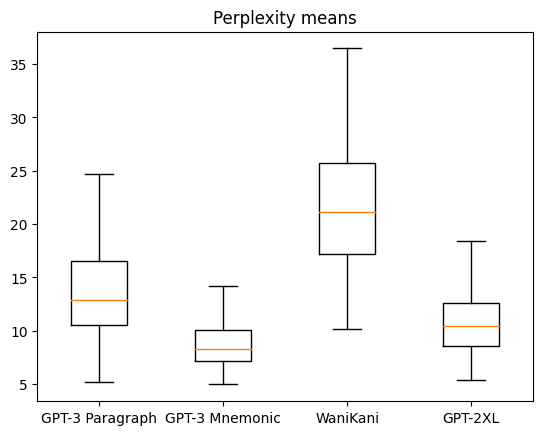

In [20]:
box_plot(ds_ppl['train'], 'Perplexity means')

In [5]:
# let's try gpt neo
from transformers import GPTNeoForCausalLM, GPT2TokenizerFast

model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer = GPT2TokenizerFast.from_pretrained("EleutherAI/gpt-neo-1.3B")

model = model.to(device)

In [21]:
print(anova(ds_ppl['train']))

4.227575349662175e-53


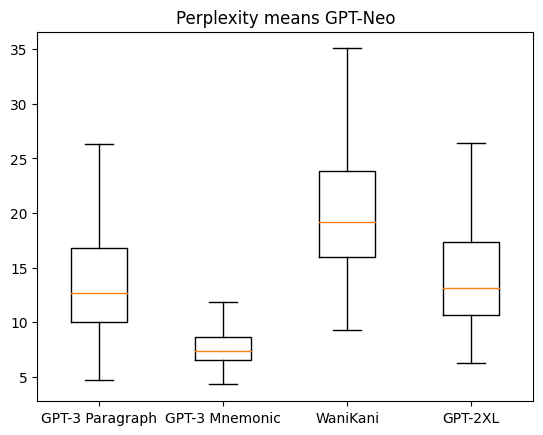

In [22]:
box_plot(ds_ppl['train'], 'Perplexity means GPT-Neo')